In [1]:
import pandas
import seaborn

In [2]:
df = pandas.read_pickle("5-value-iterations.pkl.gz")
df

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,6,47,...,0.247012,41.488150,19,19,0.001135,2,0.291043,0.382590,0.249088,37.955464
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,6,37,...,0.192262,40.935026,17,17,0.000622,2,0.170436,0.379228,0.193370,37.484435
2,v1,generic-v1,False,False,True,True,True,bitcoin,6,21327,...,159.251793,39.915454,42,42,0.001070,2,0.122248,0.376756,159.494988,37.431885
3,v1,generic-v1,False,False,True,True,True,ethereum_3,6,32961,...,283.480204,55.142094,357,357,0.009678,2,0.144579,0.517720,284.062479,51.178889
4,v1,generic-v1,False,False,True,True,True,byzantium_3,6,33016,...,227.124544,38.998731,110,110,0.001724,2,0.124940,0.365913,227.734735,36.179560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,v1+fc+n,generic-v1,True,True,True,True,True,byzantium_3,6,572,...,3.070160,48.973141,89,89,0.001615,2,0.185071,0.476153,3.078089,46.876306
92,v1+fc+n,generic-v1,True,True,True,True,True,ghostdag_3,6,604,...,2.644354,42.580938,47,47,0.001011,2,0.191304,0.411187,2.651835,40.268141
93,v1+fc+n,generic-v1,True,True,True,True,True,parallel_3,6,492,...,3.109200,55.061288,112,112,0.002013,2,0.192119,0.543091,3.116842,53.057343
94,v0+fc+n,generic-v0,True,True,True,True,True,bitcoin,6,501,...,4.269770,57.377046,64,64,0.001228,2,0.198653,0.551257,4.278848,54.775965


In [3]:
df.columns

Index(['problem', 'model', 'force_consider_own', 'merge_isomorphic',
       'truncate_common_chain', 'collect_garbage', 'reward_common_chain',
       'protocol', 'dag_size_limit', 'size', 'time_spent', 'rss', 'mdp',
       'horizon', 'alpha', 'gamma', 'vi_discount', 'vi_delta', 'vi_stop_delta',
       'vi_progress', 'vi_iter', 'vi_max_iter', 'vi_time', 'vi_max_value',
       'ss_reachable', 'ss_nonzero', 'ss_time', 'pe_iter', 'ptrev', 'rpp',
       'time', 'vi_steady_value'],
      dtype='object')

In [4]:
dsl = df.dag_size_limit.drop_duplicates()
assert len(dsl) == 1
dag_size_limit = dsl.iloc[0]
dag_size_limit

6

# Reward per progress, source-model, steady state

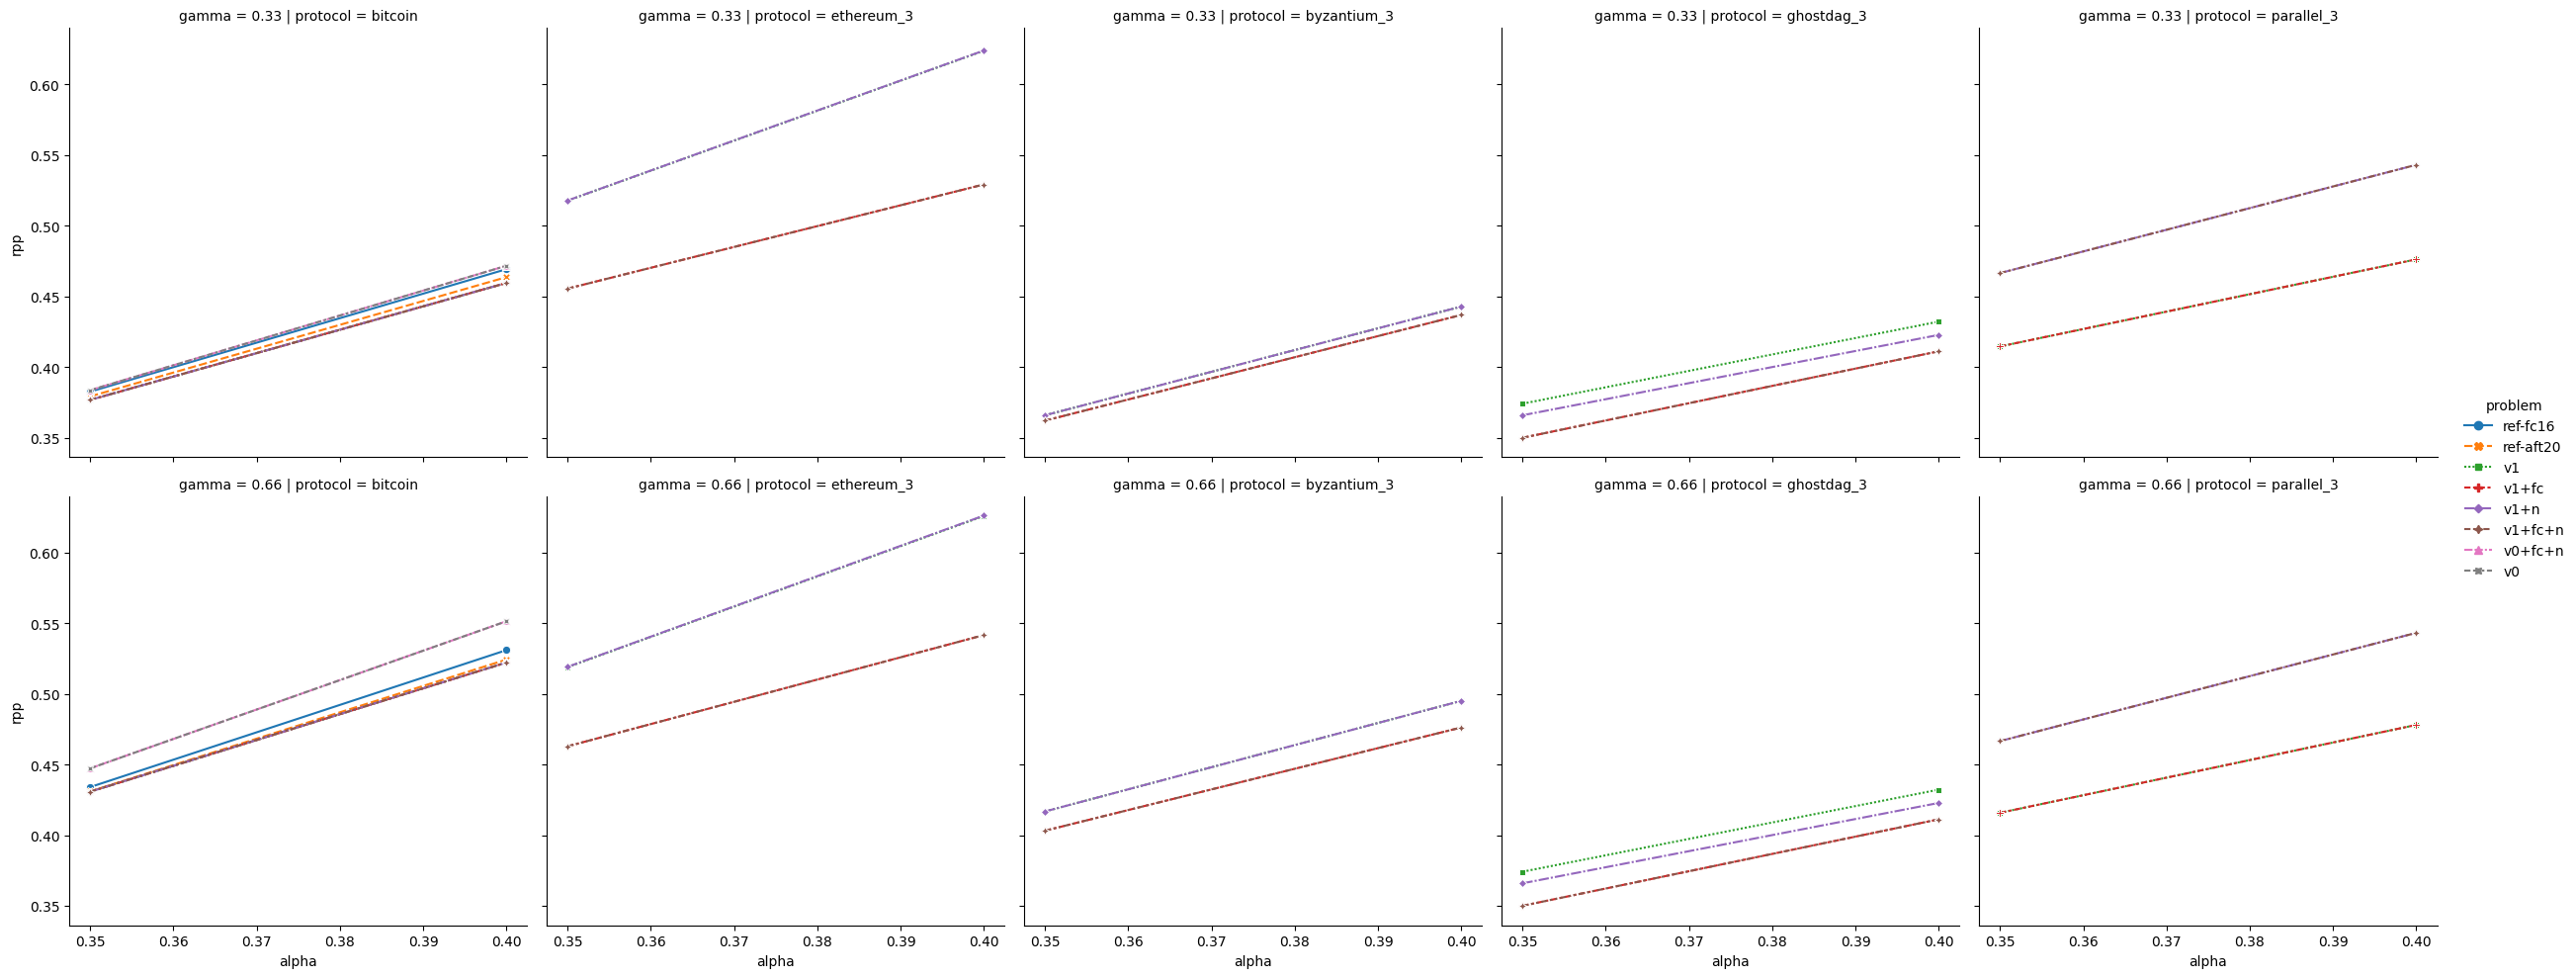

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="protocol",
    row="gamma",
)

## Validation v0

The following was lining up perfectly for the first preprint version at maximum fork length = 13

In [6]:
dag_size_limit

6

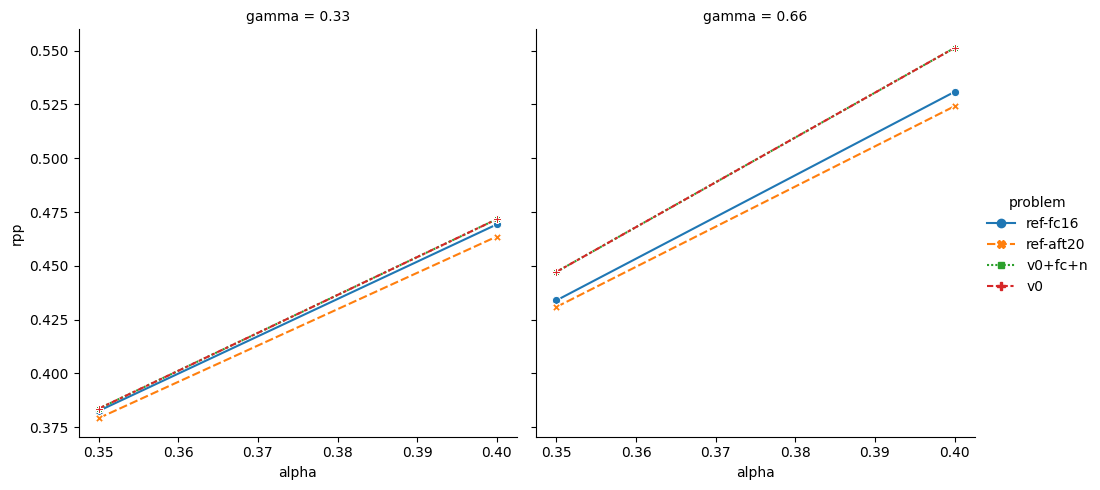

In [7]:
seaborn.relplot(
    data=df.query(
        'protocol == "bitcoin" and (problem.str.startswith("ref") or problem == "v0+fc+n" or problem == "v0")'
    ),
    kind="line",
    x="alpha",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="gamma",
)

## Validation v1

The following should line up; I want to claim it in the paper

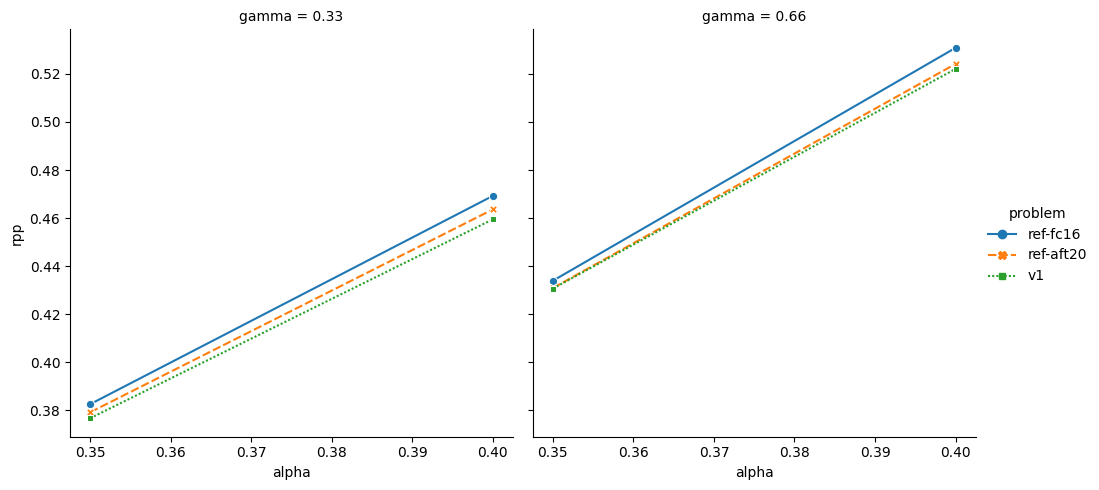

In [8]:
seaborn.relplot(
    data=df.query(
        'protocol == "bitcoin" and (problem.str.startswith("ref") or problem == "v1")'
    ),
    kind="line",
    x="alpha",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="gamma",
)

## H: v1 optimizations are neutral for all protocols

No. Exceptions:
- In Ethereum and Byzantium force-consider restricts the attacker. The optimal policy ignores some own blocks.
- In Parallel, canonization seems to enable attacks. I have no glue how this can be.
- In Ghostdag, canonization seems to mitigate attacks. I have no glue how this can be.
- In Ghostdag, canonization causes a split such that force-consider mitigates attacks. I have no glue how this can be.

In [ ]:
seaborn.relplot(
    data=df.query('problem.str.startswith("v1")'),
    kind="line",
    x="alpha",
    y="rpp",
    style="force_consider_own",
    hue="merge_isomorphic",
    markers=True,
    col="protocol",
    row="gamma",
)

# Prepare CSV for paper

In [ ]:
rpp_of_alpha = df.assign(
    column=lambda d: [
        f"{r.problem}:{r.protocol}:gamma{str(r.gamma)[2:]}:dsl{r.dag_size_limit}"
        for _, r in d.iterrows()
    ]
).pivot(index="alpha", columns="column", values="rpp")
rpp_of_alpha.to_csv("5-rpp-of-alpha.csv")
rpp_of_alpha